In [2]:
import os
import json
import random
import copy
import datasets
from PIL import Image, ImageDraw
import numpy as np
from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor, AutoTokenizer, ViTFeatureExtractor
import torch

import matplotlib.pyplot as plt

os.environ["WANDB_DISABLED"] = "true"

2023-03-26 14:12:16.518030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 14:12:17.074193: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/braian/anaconda3/envs/thesis/lib/
2023-03-26 14:12:17.076332: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/braian/anaconda3/envs/thesis/lib/
2023-03-26 14:12:17.076340: W tensorflow/compile

In [3]:
# import nltk
# try:
#     nltk.data.find("tokenizers/punkt")
# except (LookupError, OSError):
#     nltk.download("punkt", quiet=True)

In [4]:
# enc_args = {"output_attentions": True}

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning", output_attentions=True)
model.config.encoder.output_attentions = True
model.config.encoder.output_hidden_states = True
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
print(type(feature_extractor))
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams, "output_attentions": 'true'}

/mnt/c/Users/braia/Documents/github/transformers/src/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,


<class 'transformers.models.vit.feature_extraction_vit.ViTFeatureExtractor'>
cpu


In [5]:
# model.config

In [16]:
#requires more inputs
def forward_pass(img):
    # text preprocessing step
    def tokenization_fn(captions, max_target_length):
        """Run tokenization on captions."""
        labels = tokenizer(captions, 
                          padding="max_length", 
                          max_length=max_target_length,return_tensors="pt").input_ids

        return labels

    pixel_values = feature_extractor(images=[img], return_tensors='pt').pixel_values
    pixel_values = pixel_values.to(device)
    ## Can we use without this input???
    text = "hello world"
    labels = tokenization_fn(text, 128)
    labels = labels.to(device)
    outputs = model(pixel_values=pixel_values, labels=labels)
    return outputs

## Sanity check

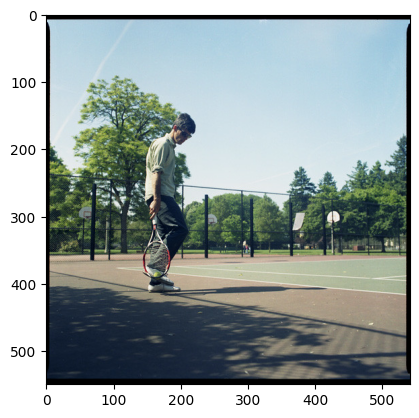

In [17]:
sample_image = Image.open('./526736409_b5dff13989_z.jpg').convert(mode="RGB")
plt.imshow(sample_image)

In [18]:
outputs = forward_pass(sample_image)

TypeError: forward() got an unexpected keyword argument 'max_length'

In [14]:
outputs.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'encoder_last_hidden_state', 'encoder_hidden_states', 'encoder_attentions'])

In [15]:
outputs['past_key_values']

((tensor([[[[-0.4639,  1.0217,  0.5178,  ..., -1.3494,  0.0604,  0.9517],
            [-0.7334,  1.9226,  0.9999,  ...,  0.4131, -0.5772,  1.8671],
            [-2.5377,  3.3270,  1.0649,  ...,  0.2601, -2.5511,  1.0685],
            ...,
            [ 1.3942,  0.2825,  2.6967,  ..., -1.8758,  0.7040,  0.2510],
            [ 1.4099,  0.2855,  2.6331,  ..., -1.8402,  0.7300,  0.1703],
            [ 1.4221,  0.2667,  2.6552,  ..., -1.8354,  0.7010,  0.2292]],
  
           [[-0.1709,  1.3958, -0.7572,  ...,  0.8681, -0.1085,  0.5793],
            [-1.2180, -1.6903, -1.0928,  ...,  0.6989,  2.7132,  0.4337],
            [ 1.1257,  0.0068, -1.7065,  ..., -0.6050,  3.3456, -1.0113],
            ...,
            [-0.8286,  2.0187, -1.4355,  ...,  1.4003, -0.7268,  0.4602],
            [-0.8323,  2.0117, -1.4338,  ...,  1.4128, -0.7592,  0.4551],
            [-0.8419,  2.0278, -1.4342,  ...,  1.4314, -0.7499,  0.4275]],
  
           [[-0.6023,  0.1136,  0.7381,  ..., -0.0071, -2.5050, -0.144

In [9]:
len(outputs.encoder_attentions)

12

In [10]:
outputs.encoder_attentions[0].shape

torch.Size([1, 12, 197, 197])

In [11]:
len(outputs.encoder_hidden_states)

13

In [12]:
outputs.encoder_hidden_states[0].shape

torch.Size([1, 197, 768])

### mask extraction
**Options:**
* Object 1: 
    * biggest object in MAIN class
    * merge all masks of MAIN class into one
* Object 2 
    * biggest object in SECONDARY class
    * merge all masks of SECONDARY class into one
* ...

In [13]:
COCO_PATH = "../../../datasets/coco"

In [14]:
with open("../task1_person_accessory_data_w_caption.json", "r") as f:
    person_annotations = json.load(f)

# with open("../task2_dining_objects_data.json", "r") as f:
#     dining_obj_annotations = json.load(f)    

In [15]:
person_annotations.keys()

dict_keys(['27', '28', '31', '32', '33'])

In [17]:
# dining_obj_annotations.keys()

In [18]:
person_annotations['27'][0]["annotations"]

{'annotations': [{'segmentation': [[347.95,
     87.38,
     347.43,
     104.12,
     351.09,
     115.63,
     355.27,
     135.52,
     355.27,
     137.09,
     359.46,
     169.0,
     371.49,
     181.04,
     399.23,
     178.42,
     432.19,
     137.61,
     440.56,
     114.59,
     446.84,
     106.74,
     474.05,
     92.61,
     462.01,
     57.56,
     403.94,
     54.94,
     372.02,
     70.11,
     357.37,
     82.15,
     346.38,
     87.38]],
   'area': 10204.53555,
   'iscrowd': 0,
   'image_id': 225919,
   'bbox': [346.38, 54.94, 127.67, 126.1],
   'category_id': 18,
   'id': 2280},
  {'segmentation': [[169.73,
     139.03,
     172.05,
     132.27,
     173.21,
     129.76,
     171.08,
     128.02,
     169.73,
     127.05,
     170.31,
     120.1,
     171.85,
     115.84,
     173.01,
     112.37,
     173.01,
     109.66,
     173.59,
     106.18,
     175.52,
     106.18,
     181.32,
     107.15,
     183.45,
     105.41,
     184.99,
     106.38,
     190.

In [19]:
# TODO: 
# * get secondary object based on proximity - closest object
# * limit objects closer to the main cluster of activation
#   or choose the main object from area in main cluster of activation 
def get_bbox_center(annotation):
     return np.array((annotation["bbox"][0] + int(annotation["bbox"][2]/2), 
             annotation["bbox"][1] + int(annotation["bbox"][3]/2)))

def get_largest_mask(annotation, obj, img_draw):
    # select main (largest) mask for the object class        
    objects_area = [(ann['id'], ann['area']) for ann in annotation['annotations']['annotations'] if ann['category_id']==obj and ann['iscrowd']==0]
    largest_obj = sorted(objects_area, key=lambda x: x[1], reverse=True)[0]
    largest_obj_ann = [ann for ann in annotation['annotations']['annotations'] if ann['id']==largest_obj[0]]
    largest_obj_ann = largest_obj_ann[0] #avoid more than one object with same area
    segmentation = [ann['segmentation'] for ann in annotation['annotations']['annotations'] if ann['id']==largest_obj_ann["id"]]
    for segment in segmentation[0]:
        try:
            img_draw.polygon(segment, fill ="#ffffff")
        except ValueError:
            return None
    return [largest_obj_ann]
    
def get_all_masks(annotation, obj, img_draw):
    segmentation = [ann['segmentation'] for ann in annotation['annotations']['annotations'] if ann['category_id']==obj]
    for segment in segmentation:
        if isinstance(segment, list):
            try:
                img_draw.polygon(segment[0], fill ="#ffffff")
            except ValueError:
                return None
    return None

def get_objects_mask(annotation, objects=[], option=1):
#     sample_image_ann = person_annotations['27'][11]
    sample_image = Image.open(os.path.join(COCO_PATH, 'train2017', annotation['image']['file_name'])).convert('RGB')    
    masks = []
    for idx, obj in enumerate(objects):
        pil_mask = np.zeros(shape=sample_image.size, dtype=np.uint8)
        pil_mask = Image.fromarray(np.moveaxis(pil_mask, 0, -1))
        img_draw = ImageDraw.Draw(pil_mask) 
        
        if option == 1:
            get_largest_mask(annotation, obj, img_draw)

        # merge all masks of the object class into one
        if option == 2:
            get_all_masks(annotation, obj, img_draw)    
                    
        # get closest mask based on a reference mask (first object)
        # calculate the centroid and then find the other mask closest to this centroid
        # using euclidian distance
        if option == 3:
            ## assume first object is the reference. Get the first object based on biggest mask
            if idx==0:
                ref_annotation = get_largest_mask(annotation, obj, img_draw)[0]
            else:
                ref_center = get_bbox_center(ref_annotation)
                distances = [(np.linalg.norm(ref_center - get_bbox_center(ann)), ann["id"]) for ann in annotation['annotations']['annotations'] if ann['category_id']==obj]
                closest_obj = distances[0]
                segmentation = [ann['segmentation'] for ann in annotation['annotations']['annotations'] if ann['id']==closest_obj[1]]
                for segment in segmentation[0]:
                    try:
                        img_draw.polygon(segment, fill ="#ffffff")
                    except ValueError:
                        return None
        
        masks.append(pil_mask)
    return masks

In [20]:
## 

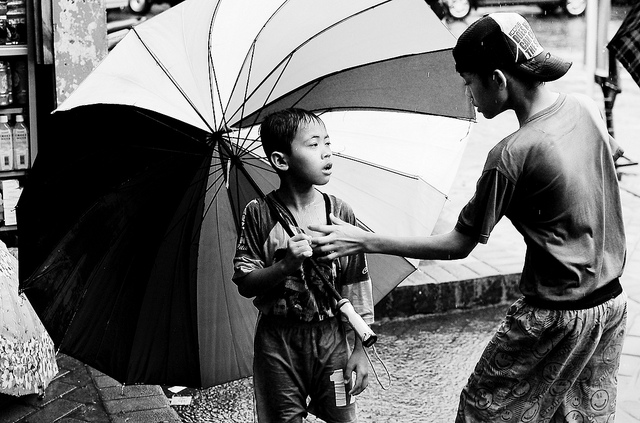

In [21]:
sample_ann = person_annotations['28'][6]
sample_img = Image.open(os.path.join(COCO_PATH, 'train2017', sample_ann['image']['file_name'])).convert('RGB')    
sample_img

2
(423, 640)


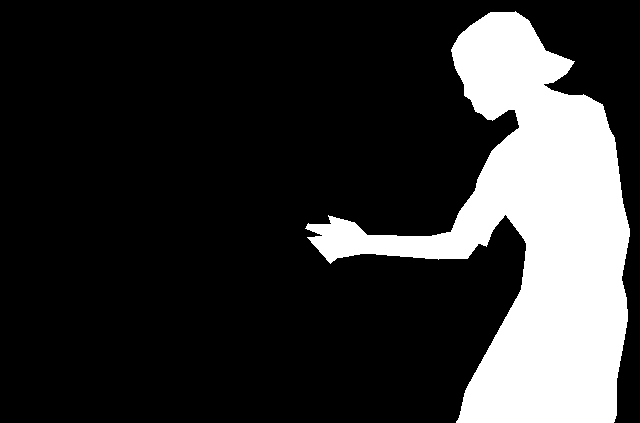

In [22]:
masks = get_objects_mask(sample_ann, objects=[1, 28], option=1)
# masks = get_objects_mask(sample_ann, objects=[67, 44], option=3)
print(len(masks))
print(np.array(masks[0]).shape)
masks[0]

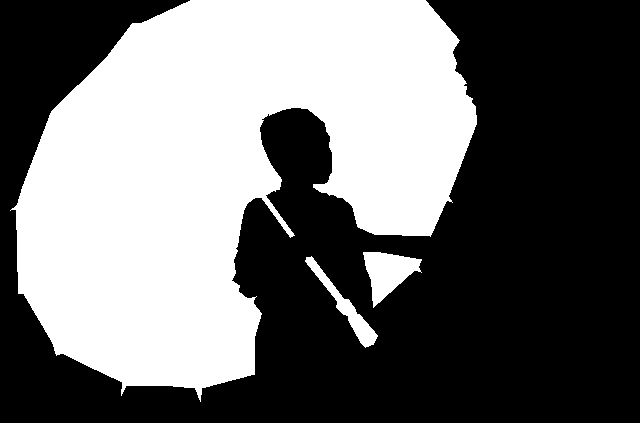

In [23]:
masks[1]

### Relevant token extraction

In [24]:
#grid_size = int(np.sqrt(mean_att_map[:,1:,1:].size(-1)))
grid_size = 14

In [25]:
def is_patch_within_mask(original_img_mask, patch_coord, mask_threshold=.70):
    patch_with_mask = original_img_mask[patch_coord[0]:patch_coord[1], patch_coord[2]:patch_coord[3],:]
    # previously was dividing by 768, why? 768 is the embbedding size...
    perc_bg = len(patch_with_mask[patch_with_mask==255]) / len(patch_with_mask.flatten())

    return perc_bg > mask_threshold, patch_with_mask

def find_original_img_patch(vit_patch:int, original_img, grid_size:int=14, patch_size:int=16):
#     h_p, w_p = vit_patch
#     projection = original_img[h_p * patch_size:(h_p * patch_size)+patch_size, w_p * patch_size:(w_p * patch_size)+patch_size]
    col_p = vit_patch // grid_size
    row_p = vit_patch - (col_p * grid_size)
    y = row_p * patch_size
    width = patch_size
    x = col_p * patch_size
    height = patch_size
    projection = original_img[x:x+width, y:y+height]
    return projection, (x, x+width, y, y+height)

### Get tokens:
1. Maximum and minimum attention token in the region for object 1. 
2. Maximum and minimum attention token from object 2. 
3. A Random token each from both objects. 
4. Max token from the whole image
5. The token consistently paid attention in last 3 layers. (from the whole image? or just FG?)

All the tokens are per layer, is it the best way to do?

In [26]:
def xy_coord_token(token, grid_size=14):
    y = token // grid_size
    x = token - (y * grid_size)
    return x, y

def find_mask_tokens(img, mask, mask_threshold, n_tokens = 196):
    img_patches = []
    mask_patches = np.zeros((n_tokens), dtype="bool")
    mask_tokens = []
    for patch_i in range(n_tokens):
        img_patch, coord = find_original_img_patch(patch_i, img)
        mask_patches[patch_i] = is_patch_within_mask(mask, coord, mask_threshold)[0]
        if mask_patches[patch_i]:
            mask_tokens.append(patch_i)
        img_patches.append(img_patch)
        
    return mask_tokens, mask_patches, img_patches

# TODO: Improve logic of consistent tokens to account for different variations of layers and not only the last N
def find_tokens_in_region(attention_map:np.array, 
                          img: np.array, 
                          mask: np.array, 
                          layers=[9,10,11], 
                          min_n=3, 
                          max_n=20,
                          mask_threshold=.75,
                          display_token_grid=False,
                          display_att_layers=False):
    tokens = {}
    all_top_n = []
    
    if display_token_grid:
        # show original mask
        plt.figure(figsize=(6, 6))
        plt.imshow(mask)
        plt.show()
        # set up the plot with 14x14 image patches
        fig, axs = plt.subplots(nrows=14, ncols=14, figsize=(6, 6))
    
    # find which tokens belong to the mask
    mask_tokens, mask_patches, img_patches = find_mask_tokens(img, mask, mask_threshold)
    # If there are not tokens related to the mask, it is probably
    # because the mask region inside the patch is too small
    # try to find mask tokens again with threshold=0.
    #    e.g.: if one pixel falls into the mask patch it means it is a mask token/patch
    if not mask_tokens:
        mask_tokens, mask_patches, img_patches = find_mask_tokens(img, mask, mask_threshold=0)
        if not mask_tokens:
            return None, None, None
        
    # for each n_layers in the attention_map
    # find all tokens
    for layer_no in layers: #enumerate(attention_map[n_layers:, :, :]):
        layer = attention_map[layer_no, :, :]
        tokens_layer_i = {}
        
        # MAX token whole image
        tokens_layer_i['max_image'] = np.argmax(layer[0, 1:].cpu().detach().numpy())
        
        # set all background activation WITHIN background mask to -1
        img_att_map_mask = copy.deepcopy(layer[0, 1:].cpu().detach().numpy())
        img_att_map_mask[~mask_patches] = 0
        
        # MIN MAX token within object/mask
        max_token_obj_layer_i = np.argmax(img_att_map_mask)
        # TODO: Improve logic to get min attention token considering only one region. 
        # when slicing np.array and using np.argmin the index returned is not relative to original array anymore
        # e.g.: np.argmin(img_map_fg[fg_mask_patch]) will return an index relative to the new array img_map_fg[fg_mask_patch]
        min_token_obj_layer_i = 0
        min_activation = np.max(img_att_map_mask)
        for token_i in mask_tokens:
            if img_att_map_mask[token_i] < min_activation:
                min_token_obj_layer_i = token_i
                min_activation = img_att_map_mask[token_i]

        tokens_layer_i['max_obj'] = max_token_obj_layer_i
        tokens_layer_i['min_obj'] = min_token_obj_layer_i
        
        # RANDOM token within object
        tokens_layer_i['random_obj'] = random.choice(mask_tokens)
        
        # Get top N activations of the layer
        # based on https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        top_n = np.argpartition(img_att_map_mask, -1 * max_n)[-1 * max_n:]
        top_n = top_n[np.argsort(img_att_map_mask[top_n])]
        top_n = top_n[::-1]
        all_top_n.append(top_n)  
        
        tokens[layer_no] = tokens_layer_i

        # show grid with all tokens found
        if display_token_grid:
            for patch_i, img_patch in enumerate(img_patches):
                row_p, col_p = xy_coord_token(patch_i)
                if mask_patches[patch_i]:
                    axs[col_p, row_p].imshow(img_patch)                       
                else:
                    axs[col_p, row_p].imshow(np.zeros_like(img_patch))
    #                 axs[col_p, row_p].set_title(mask_patches[patch_i])
                axs[col_p, row_p].axis('off')
            plt.show()
            
        if display_att_layers:
            plt.figure(figsize=(3, 3))
#             plt.imshow(layer[0, 1:].cpu().detach().numpy().reshape(grid_size, grid_size))
            plt.imshow(img_att_map_mask.reshape(grid_size, grid_size))
            plt.title(f"layer {layer_no}, shape {img_att_map_mask.shape} ")
            row_p, col_p = xy_coord_token(tokens_layer_i['min_obj'])
            plt.scatter(row_p, col_p, marker='_', c='blue')
            row_p, col_p = xy_coord_token(tokens_layer_i['max_obj'])
            plt.scatter(row_p, col_p, marker='+', c='red')
            row_p, col_p = xy_coord_token(tokens_layer_i['random_obj'])
            plt.scatter(row_p, col_p, marker='*', c='green')
            row_p, col_p = xy_coord_token(tokens_layer_i['max_image'])
            plt.scatter(row_p, col_p, marker='P', c='orange')
            plt.show()
    
    consistent_token = None
#     # FOR CONSISTENT TOKEN ACROSS SEVERAL LAYERS
#     # find if there's intersection with previous layer
#     for n in range(min_n, max_n, 2):
#         common_tokens = set()
#         for layer_no, layer_top_n in enumerate(all_top_n):
#             if layer_no==0:
#                 common_tokens = set(layer_top_n[:n])                
#             else:
#                 common_tokens = common_tokens.intersection(set(layer_top_n[:n]))
#                 if not common_tokens:
# #                     print(f"No common token with top {n}")
#                     break
#         if common_tokens:
# #             print(f"found common tokens with top {n}")
#             consistent_token = list(common_tokens)
#             if len(consistent_token)>1:
#                 # sum selected tokens across all layers to get top 1
#                 sums = dict(zip(consistent_token, [0] * len(consistent_token)))
#                 for layer in attention_map[n_layers:, :, :]:
#                     for token in consistent_token:
#                         sums[token] += layer[0, token].cpu().detach().numpy()
# #                 print(sums)
#                 consistent_token = max(sums, key=sums.get)
# #                 print(consistent_token)
#             else:
#                 consistent_token = consistent_token[0]
#             break    

    return tokens, consistent_token, all_top_n

### Attention map extraction

In [27]:
def extract_bg_token(img: Image.Image, mask:np.array, layers:list, mask_threshold=.75, renorm_weights=True, debug=False):
#     x = transform(img)
#     logits, att_map, layer_activations = model(x.unsqueeze(0))    
    ################################################
    outputs = forward_pass(img)
    layer_activations = outputs.encoder_hidden_states
    
    att_map = outputs.encoder_attentions    
    att_map = torch.stack(att_map)
    att_map = att_map.squeeze(1)

    # Average the attention weights across all heads.
    att_map = torch.mean(att_map, dim=1)
    mean_att_map = att_map
    
    grid_size = int(np.sqrt(mean_att_map[:,1:,1:].size(-1)))
#     print(grid_size)
    
    if renorm_weights:
        residual_att = torch.eye(mean_att_map.size(1))
        residual_att = residual_att.to(device)
        aug_mean_map = mean_att_map + residual_att
        aug_mean_map = aug_mean_map / aug_mean_map.sum(dim=-1).unsqueeze(-1)
        mean_att_map = aug_mean_map
        
    # some regions of the image have intermediate values between 0 and 255
    # maybe resizing the image create these "intermediate" pixels.
    fg_mask_img = copy.deepcopy(mask)
    fg_mask_img[fg_mask_img==255] = 255
    fg_mask_img[fg_mask_img!=255] = 0
    fg_mask_img = fg_mask_img[:,:,np.newaxis]
    # get background mask by reversing the image mask
    bg_mask_img = copy.deepcopy(fg_mask_img)
    bg_mask_img[fg_mask_img==255] = 0
    bg_mask_img[fg_mask_img!=255] = 255
    
#     bg_tokens, consistent_bg_token, _ = find_tokens_in_region(mean_att_map, np.array(img), bg_mask_img, mask_threshold=mask_threshold,
#                                                               display_token_grid=debug, display_att_layers=debug)
    fg_tokens, consistent_fg_token, _ = find_tokens_in_region(attention_map=mean_att_map, 
                                                              img=np.array(img), 
                                                              mask=fg_mask_img, 
                                                              layers=layers,
                                                              mask_threshold=mask_threshold,
                                                              display_token_grid=debug, 
                                                              display_att_layers=debug)
    
    return fg_tokens, consistent_fg_token, mean_att_map, layer_activations

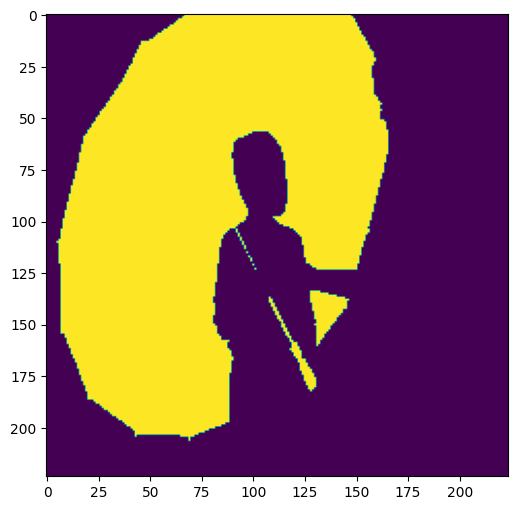

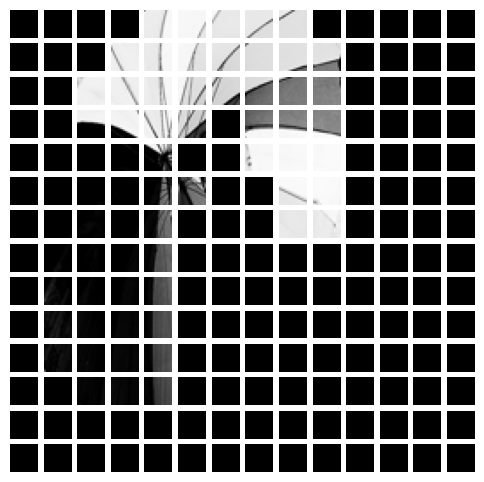

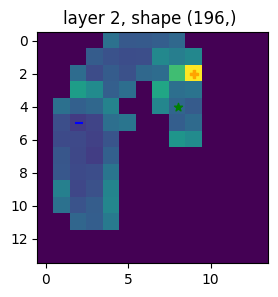

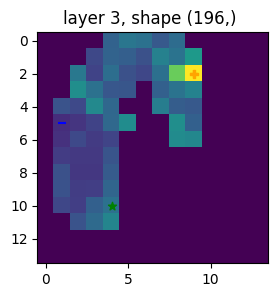

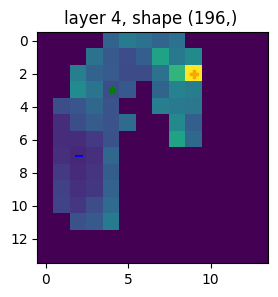

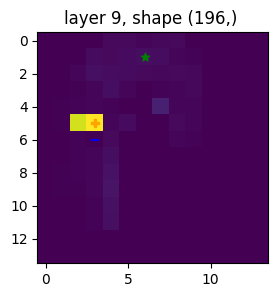

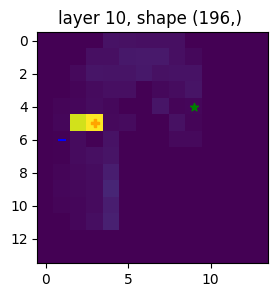

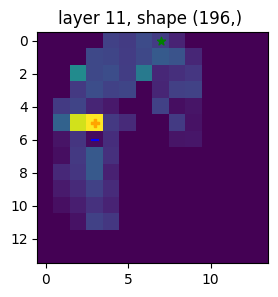

In [28]:
fg_tokens, cons_fg_token, mean_att_map, layer_activations= extract_bg_token(img=sample_img.resize((224,224)), 
                                                                            mask=np.array(masks[1].resize((224,224))),
                                                                            layers=[2,3,4,9,10,11],
                                                                            debug=True)

In [29]:
fg_tokens

{2: {'max_image': 37, 'max_obj': 37, 'min_obj': 72, 'random_obj': 64},
 3: {'max_image': 37, 'max_obj': 37, 'min_obj': 71, 'random_obj': 144},
 4: {'max_image': 37, 'max_obj': 37, 'min_obj': 100, 'random_obj': 46},
 9: {'max_image': 73, 'max_obj': 73, 'min_obj': 87, 'random_obj': 20},
 10: {'max_image': 73, 'max_obj': 73, 'min_obj': 85, 'random_obj': 65},
 11: {'max_image': 73, 'max_obj': 73, 'min_obj': 87, 'random_obj': 7}}

In [30]:
cons_fg_token

In [31]:
# Display tokens
# plt.imshow(mean_att_map[-1,0,1:].cpu().detach().numpy().reshape(grid_size, grid_size))
# col_p = token // grid_size
# row_p = token - (col_p * grid_size)
# plt.scatter(row_p, col_p, marker='*', c='red')

In [32]:
type(layer_activations)

tuple

In [33]:
len(layer_activations)

13

# Extract tokens from datasets

In [34]:
import pandas as pd
from tqdm import tqdm

In [35]:
person_annotations['27'][0].keys()

dict_keys(['annotations', 'image'])

In [38]:
labels_map = {27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase'}
labels = ['backpack', 'umbrella', 'handbag', 'tie', 'suitcase']
# (1, 27) ('person', 'backpack'): 3524
# (1, 28) ('person', 'umbrella'): 2089
# (1, 31) ('person', 'handbag'): 4890
# (1, 32) ('person', 'tie'): 1543
# (1, 33) ('person', 'suitcase'): 1048
labels_to_idx = dict(zip(labels, range(len(labels))))
labels_to_idx

{'backpack': 0, 'umbrella': 1, 'handbag': 2, 'tie': 3, 'suitcase': 4}

In [37]:
labels_map = {27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 
              44: 'bottle', 47: 'cup', 48: 'fork', 49: 'knife', 51: 'bowl', 62: 'chair'}
labels = ['backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'bottle', 'cup', 'fork', 'knife', 'bowl', 'chair']
# (67, 44) ('dining table', 'bottle'): 1060
# (67, 47) ('dining table', 'cup'): 1919
# (67, 48) ('dining table', 'fork'): 1191
# (67, 49) ('dining table', 'knife'): 1066
# (67, 51) ('dining table', 'bowl'): 1793
# (67, 62) ('dining table', 'chair'): 1898
labels_to_idx = dict(zip(labels, range(len(labels))))
labels_to_idx

{'backpack': 0,
 'umbrella': 1,
 'handbag': 2,
 'tie': 3,
 'suitcase': 4,
 'bottle': 5,
 'cup': 6,
 'fork': 7,
 'knife': 8,
 'bowl': 9,
 'chair': 10}

In [39]:
annotation_groups = {1: person_annotations}
CAPTION_FILTER = True

In [40]:
for main_class, annotations_file in annotation_groups.items():
    for second_class, task_annotations in annotations_file.items():
        features = {
    #                 "main_bg_tokens": [],
    #                 "main_consistent_bg_token": [],
                    "main_fg_tokens": [],
                    "main_consistent_fg_token": [],
    #                 "second_bg_tokens": [],
    #                 "second_consistent_bg_token": [],
                    "second_fg_tokens": [],
                    "second_consistent_fg_token": [],
#                     "layer_11_act": [],
#                     "layer_10_act": [],
#                     "layer_09_act": [],
                    "layers_act": [],
                    "class": []}

        print(f"class ({main_class}, {second_class})")
        for idx, ann in enumerate(tqdm(task_annotations)):
            if CAPTION_FILTER and not ann['annotations']['second_object_in_caption']:
                continue
            img = Image.open(os.path.join(COCO_PATH, 'train2017', ann['image']['file_name'])).convert('RGB')    
            masks = get_objects_mask(ann, objects=[int(main_class), int(second_class)], option=3)
            if masks is not None:
                # MAIN OBJECT
                main_fg_tokens, main_cons_fg_token, mean_att_map, activations = extract_bg_token(img=img.resize((224,224)), 
                                                                                                 mask=np.array(masks[0].resize((224,224))),
                                                                                                 layers=[2,3,4,9,10,11],
                                                                                                 mask_threshold=.50)
                # SECOND OBJECT
                sec_fg_tokens, sec_cons_fg_token, _, _ = extract_bg_token(img=img.resize((224,224)), 
                                                                          mask=np.array(masks[1].resize((224,224))),
                                                                          layers=[2,3,4,9,10,11],
                                                                          mask_threshold=.30)
                if main_fg_tokens is not None and sec_fg_tokens is not None:
    #                 features["main_bg_tokens"].append(bg_tokens)
    #                 features["main_consistent_bg_token"].append(cons_bg_token)
                    features["main_fg_tokens"].append(main_fg_tokens)
                    features["main_consistent_fg_token"].append(main_cons_fg_token)
    #                   features["second_bg_tokens"].append(bg_tokens)
    #                 features["second_consistent_bg_token"].append(cons_bg_token)
                    features["second_fg_tokens"].append(sec_fg_tokens)
                    features["second_consistent_fg_token"].append(sec_cons_fg_token)

#                     features["layer_11_act"].append(activations[11].cpu().squeeze().detach().numpy())
#                     features["layer_10_act"].append(activations[10].cpu().squeeze().detach().numpy())
#                     features["layer_09_act"].append(activations[9].cpu().squeeze().detach().numpy())
                    layers_act = [layer_act.cpu().squeeze().detach().numpy() for layer_act in activations]
                    features["layers_act"].append(layers_act)
                    features["class"].append(labels_map[int(second_class)])
    #         else:
    #             print(f"error generating mask for image_id {ann['image']}")

            if len(features["main_fg_tokens"]) > 1000:            
                break        
        feat_pd = pd.DataFrame(features)
        print(int(second_class), len(feat_pd))
        if len(feat_pd) > 0:
            feat_pd.to_pickle(f"feat_full_act_{labels_map[int(second_class)]}.pickle")

class (1, 27)


100%|██████████████████████████████████████████████████████████████████████████| 3524/3524 [00:00<00:00, 1612912.19it/s]


27 0
class (1, 28)


100%|███████████████████████████████████████████████████████████████████████████████| 2089/2089 [00:49<00:00, 42.31it/s]


28 538
class (1, 31)


100%|██████████████████████████████████████████████████████████████████████████| 4890/4890 [00:00<00:00, 1572261.14it/s]


31 0
class (1, 32)


100%|███████████████████████████████████████████████████████████████████████████████| 1543/1543 [00:15<00:00, 99.29it/s]


32 180
class (1, 33)


100%|███████████████████████████████████████████████████████████████████████████████| 1048/1048 [00:26<00:00, 39.43it/s]


33 299


In [90]:
print(len(feat_pd))
feat_pd.head()

299


,main_fg_tokens,main_consistent_fg_token,second_fg_tokens,second_consistent_fg_token,layers_act,class
0,"[{'max_image': 129, 'max_obj': 20, 'min_obj': ...",None,"[{'max_image': 129, 'max_obj': 55, 'min_obj': ...",None,"[[[-0.0021190564, 0.014390027, -0.49405986, 0....",suitcase
1,"[{'max_image': 159, 'max_obj': 159, 'min_obj':...",None,"[{'max_image': 159, 'max_obj': 166, 'min_obj':...",None,"[[[-0.0021190564, 0.014390027, -0.49405986, 0....",suitcase
2,"[{'max_image': 136, 'max_obj': 135, 'min_obj':...",None,"[{'max_image': 136, 'max_obj': 136, 'min_obj':...",None,"[[[-0.0021190564, 0.014390027, -0.49405986, 0....",suitcase
3,"[{'max_image': 69, 'max_obj': 94, 'min_obj': 1...",None,"[{'max_image': 69, 'max_obj': 162, 'min_obj': ...",None,"[[[-0.0021190564, 0.014390027, -0.49405986, 0....",suitcase
4,"[{'max_image': 147, 'max_obj': 117, 'min_obj':...",None,"[{'max_image': 147, 'max_obj': 147, 'min_obj':...",None,"[[[-0.0021190564, 0.014390027, -0.49405986, 0....",suitcase
